# Open Data repositories

1. [Ajuntament de Barcelona](#1)
2. [Generalitat de Catalunya](#2)
3. **[TASK:Load data from open data portal](#task1)**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


#### Data directory

In [2]:
data_dir = '../data/'

# 1. Ajuntament de Barcelona<a class="anchor" id=1></a>

#### **[Cataleg de Dades Obertes del Ajuntament de Barcelona](https://opendata-ajuntament.barcelona.cat/data/en/dataset)**.

In [3]:
import urllib.request
import json

url = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search?resource_id=c78c2bf7-88a6-4db9-a1e9-429f0ce14e88&limit=100000"

# Request and read the data
with urllib.request.urlopen(url) as response:
    source = response.read()

# Parse JSON
data = json.loads(source)

# Extract records (actual table content)
records = data["result"]["records"]
df = pd.DataFrame(records)

print("Shape:", df.shape)

Shape: (16771, 29)


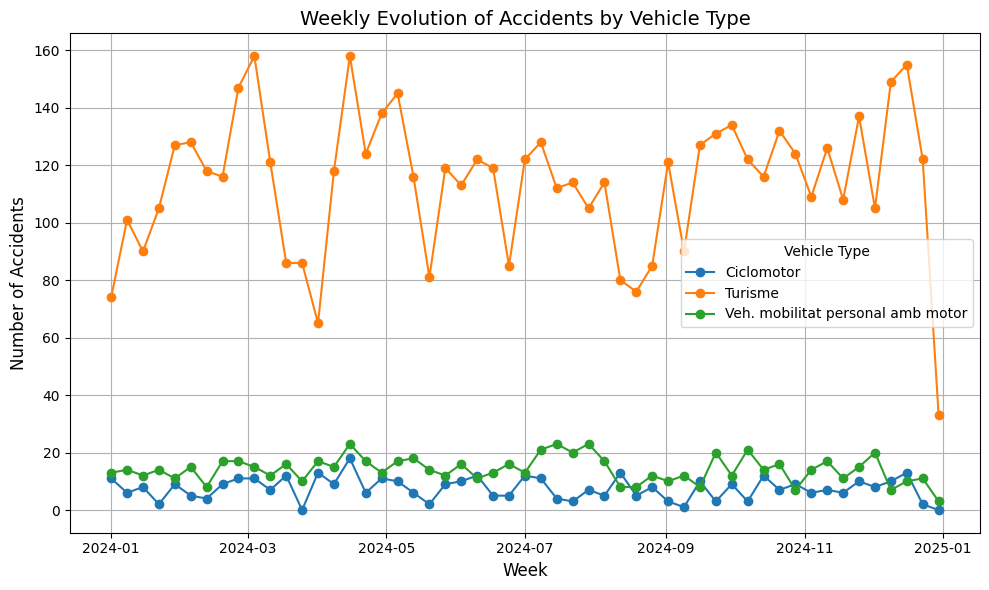

In [4]:
# Create datetime column (your code cleaned a bit)
df["Dia_mes"] = pd.to_numeric(df["Dia_mes"], errors="coerce")
df["Hora_dia"] = pd.to_numeric(df["Hora_dia"], errors="coerce")

df["datetime_str"] = (
    df["NK_ Any"].astype(str) + "-" +
    df["Mes_ any"].astype(str).str.zfill(2) + "-" +
    df["Dia_mes"].astype(int).astype(str).str.zfill(2) + " " +
    df["Hora_dia"].astype(int).astype(str).str.zfill(2) + ":00"
)

df["datetime"] = pd.to_datetime(df["datetime_str"], format="%Y-%m-%d %H:%M", errors="coerce")

# Filter only two vehicle types
types_to_plot = ["Turisme", "Ciclomotor", "Veh. mobilitat personal amb motor"]  # change names to your actual ones
df_filtered = df[df["Desc_Tipus_vehicle_implicat"].isin(types_to_plot)].copy()

# Create weekly period
df_filtered["week"] = df_filtered["datetime"].dt.to_period("W").apply(lambda r: r.start_time)

# Count accidents per week and type
weekly_counts = (
    df_filtered.groupby(["week", "Desc_Tipus_vehicle_implicat"])
    .size()
    .reset_index(name="count")
)

# Pivot for plotting
weekly_pivot = weekly_counts.pivot(index="week", columns="Desc_Tipus_vehicle_implicat", values="count").fillna(0)

# Plot
plt.figure(figsize=(10, 6))
for col in weekly_pivot.columns:
    plt.plot(weekly_pivot.index, weekly_pivot[col], marker="o", label=col)

plt.title("Weekly Evolution of Accidents by Vehicle Type", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Number of Accidents", fontsize=12)
plt.grid(True)
plt.legend(title="Vehicle Type")
plt.tight_layout()
plt.show()


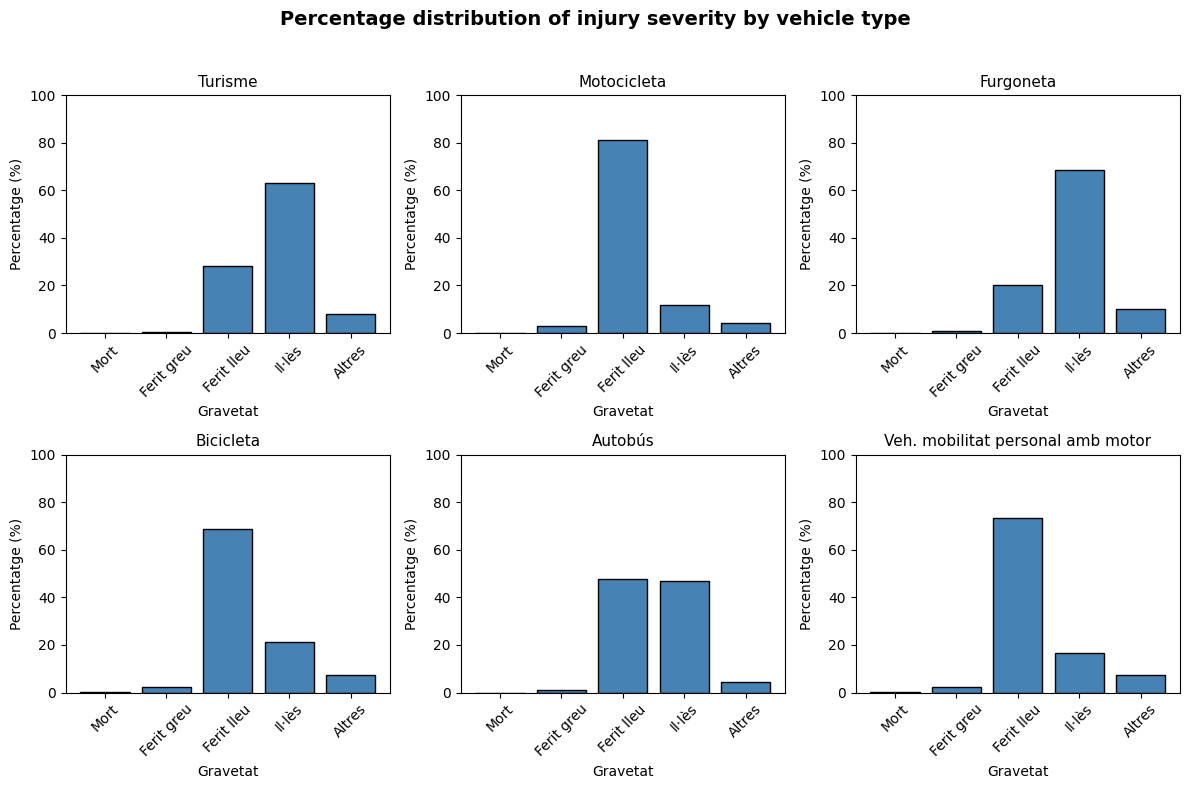

In [5]:


# Simplify victim categories
df["Descripcio_victimitzacio"] = df["Descripcio_victimitzacio"].astype(str)
victim_col = df["Descripcio_victimitzacio"].str.lower()

conditions = [
    victim_col.str.contains("lleu", na=False),
    victim_col.str.contains("greu", na=False),
    victim_col.str.contains("mort", na=False),
    victim_col.str.contains("il", na=False) | victim_col.str.contains("illes", na=False) | victim_col.str.contains("iles", na=False),
]
choices = ["Ferit lleu", "Ferit greu", "Mort", "Il·lès"]
df["victimitzacio_cat"] = np.select(conditions, choices, default="Altres")

# Select relevant columns
cols = ["Desc_Tipus_vehicle_implicat", "victimitzacio_cat"]
df_plot = df[cols].dropna()

# Select top vehicle types
top_vehicles = (
    df_plot["Desc_Tipus_vehicle_implicat"]
    .value_counts()
    .head(6)
    .index
)

# Group and compute counts
grouped = (
    df_plot[df_plot["Desc_Tipus_vehicle_implicat"].isin(top_vehicles)]
    .groupby(["Desc_Tipus_vehicle_implicat", "victimitzacio_cat"])
    .size()
    .reset_index(name="count")
)

# Compute percentage per vehicle type
grouped["percent"] = (
    grouped.groupby("Desc_Tipus_vehicle_implicat")["count"]
    .transform(lambda x: 100 * x / x.sum())
)

# Fixed order for categories
order = ["Mort", "Ferit greu", "Ferit lleu", "Il·lès", "Altres"]

# Create subplots
n = len(top_vehicles)
fig, axes = plt.subplots(nrows=2, ncols=(n + 1)//2, figsize=(12, 8))
axes = axes.flatten()

# Draw one bar plot per vehicle type
for i, vehicle in enumerate(top_vehicles):
    ax = axes[i]
    subset = grouped[grouped["Desc_Tipus_vehicle_implicat"] == vehicle]

    # Reindex to ensure fixed order and missing categories appear as 0
    subset = subset.set_index("victimitzacio_cat").reindex(order, fill_value=0).reset_index()

    ax.bar(subset["victimitzacio_cat"], subset["percent"], 
           color="steelblue", edgecolor="black")

    ax.set_title(vehicle, fontsize=11)
    ax.set_xlabel("Gravetat")
    ax.set_ylabel("Percentatge (%)")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 100)

# Adjust layout
plt.suptitle("Percentage distribution of injury severity by vehicle type", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 2. Generalitat de Catalunya<a class="anchor" id=2></a>

We here use **[Cataleg de Dades Obertes de la Generalitat de Catalunya](https://analisi.transparenciacatalunya.cat/)**, because it offers an API, reasonably good documentation, and - interesting data.

In [6]:
import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)
print("Format of dataset: ", type(client))
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# from: https://analisi.transparenciacatalunya.cat/api/v3/views/euku-fzbx/query.json
results = client.get("euku-fzbx", limit=2000) # 2000 is the number of rows that we scrape from the web page

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df.head()

2025-11-17 15:55:00,415 - WARNING - Requests made without an app_token will be subject to strict throttling limits.


Format of dataset:  <class 'sodapy.socrata.Socrata'>


,demarcaci_territorial,cif,n_mero_d_inscripci,nom,data_d_inscripci,classe_de_cooperativa,ccae,descripci_ccae,sector,subsector,adre_a,codi_postal,municipi,comarca,prov_ncia,tancament_de_l_exercici,total_socis_inicials
0,Barcelona,F60546702,6520,"GEISE, SCCL",1994-03-08T00:00:00.000,Treball associat,(7022),Altres activitats de consultoria de gestió emp...,SERVEIS,Activitats de consultoria de gestió empresarial,RBLA. Rambla núm. 5 Pis 4T,(08202),Sabadell,Vallès Occidental,BARCELONA,31/12,3
1,Barcelona,F64762487,13610,"CDIAP MARTANA, SCCL",2008-01-29T00:00:00.000,Treball associat,(8621),Activitats de medicina general,SERVEIS,Activitats mèdiques i odontològiques,C. PROVIDENCIA núm. 112 Pis 1R Porta 1A,(08024),Barcelona,Barcelonès,BARCELONA,31/12,3
2,Lleida,F25011800,694,"CAMP DE SUNYER, SCCL",1974-04-30T00:00:00.000,Agràries,(0161),Activitats de suport a l'agricultura,AGRICULTURA,"Activitats de suport a l'agricultura, ramaderi...",pista DE TORRES núm. S/N,(25174),Sunyer,Segrià,LLEIDA,30/04,90
3,Tarragona,F43754696,13070,"INDOCAR REUS, SCCL",2004-08-20T00:00:00.000,Treball associat,(4520),Manteniment i reparació de vehicles de motor,SERVEIS,Manteniment i reparació de vehicles de motor,C. PITIÜSES núm. 7 Polígon Industrial Nau 9,(43204),Reus,Baix Camp,TARRAGONA,31/12,3
4,Barcelona,F09760745,15829,"GESTIÓ DE PROJECTES SOCIALS I SOSTENIBLES, SCCL",2022-02-23T00:00:00.000,Treball associat,(6832),Gestió i administració de la propietat immobil...,SERVEIS,Activitats immobiliàries per compte d'altri,PG. DE GRACIA núm. 53,(08007),Barcelona,Barcelonès,BARCELONA,31/12,3


#### Evolution of the number of cooperatives established

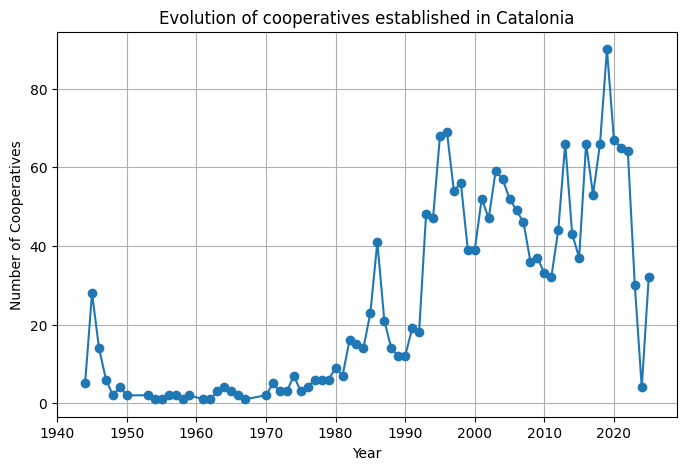

In [7]:
results_df["data_d_inscripci"] = pd.to_datetime(results_df["data_d_inscripci"], errors="coerce")

# Extract year of registration
results_df["year"] = results_df["data_d_inscripci"].dt.year

# Count number of cooperatives by year
yearly_counts = results_df["year"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(yearly_counts.index, yearly_counts.values, marker="o")
plt.title("Evolution of cooperatives established in Catalonia")
plt.xlabel("Year")
plt.ylabel("Number of Cooperatives")
plt.grid(True)
plt.show()

Observation: Sometimes a logarithmic scale helps us to visualise better the data, try with: <code>ax.semilogy()</code>.

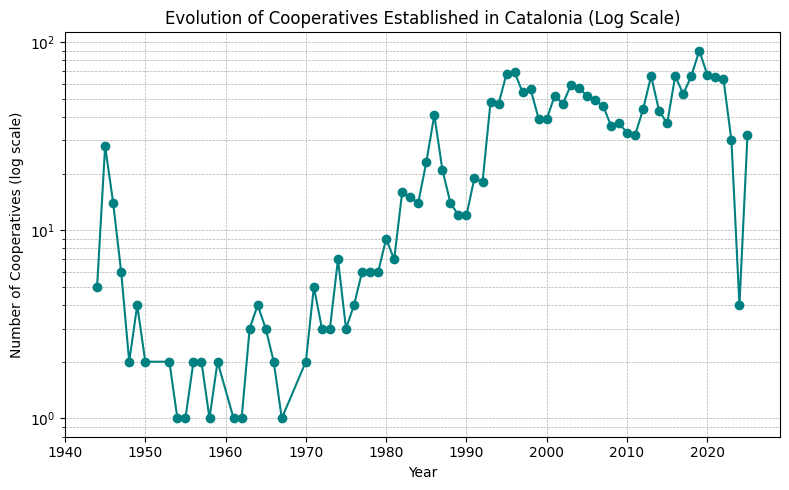

In [8]:

results_df["year"] = results_df["data_d_inscripci"].dt.year

# Count number of cooperatives by year
yearly_counts = results_df["year"].value_counts().sort_index()

# Plot (logarithmic scale)
fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogy(yearly_counts.index, yearly_counts.values, marker="o", color="teal")

ax.set_title("Evolution of Cooperatives Established in Catalonia (Log Scale)", fontsize=12)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Cooperatives (log scale)", fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


#### Number of cooperatives by sector

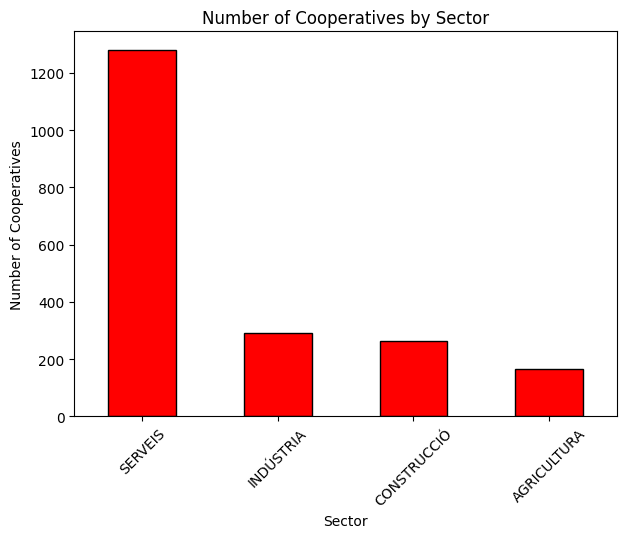

In [9]:
# Count number of cooperatives by sector
sector_counts = results_df["sector"].value_counts()

# Plot
plt.figure(figsize=(7, 5))
sector_counts.plot(kind="bar", color="red", edgecolor="black")
plt.title("Number of Cooperatives by Sector")
plt.xlabel("Sector")
plt.ylabel("Number of Cooperatives")
plt.xticks(rotation=45)
plt.show()

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load GeoJSONs for Catalonia provinces
cp_barna = gpd.read_file(data_dir + "ds-codigos-postales-master/data/BARCELONA.geojson")
cp_lleida = gpd.read_file(data_dir + "ds-codigos-postales-master/data/LLEIDA.geojson")
cp_tarragona = gpd.read_file(data_dir + "ds-codigos-postales-master/data/TARRAGONA.geojson")
cp_girona = gpd.read_file(data_dir + "ds-codigos-postales-master/data/GIRONA.geojson")

# Combine into a single GeoDataFrame
cp = gpd.GeoDataFrame(pd.concat([cp_barna, cp_lleida, cp_tarragona, cp_girona], ignore_index=True), crs=cp_barna.crs)

# Cooperative data
# Clean postal codes
results_df["codi_postal"] = results_df["codi_postal"].str.extract(r"(\d+)")

# Count number of cooperatives per postal code
postal_counts = results_df["codi_postal"].value_counts().reset_index()
postal_counts.columns = ["postal_code", "num_coops"]

# Merge cooperative counts with geospatial data
# Make sure columns have the same dtype and names
cp["COD_POSTAL"] = cp["COD_POSTAL"].astype(str)
postal_counts["postal_code"] = postal_counts["postal_code"].astype(str)

# Merge DataFrames (corrected line)
map_df = cp.merge(postal_counts, left_on="COD_POSTAL", right_on="postal_code", how="left")

# Fill missing values (postal codes with 0 cooperatives)
map_df["num_coops"] = map_df["num_coops"].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
map_df.plot(column="num_coops", cmap="YlGnBu", legend=True, ax=ax)
ax.set_title("Number of Cooperatives per Postal Code (Catalonia)", fontsize=14)
ax.axis("off")
plt.show()


2025-11-17 15:55:07,149 - ERROR - ../data/ds-codigos-postales-master/data/BARCELONA.geojson: No such file or directory


DriverError: ../data/ds-codigos-postales-master/data/BARCELONA.geojson: No such file or directory

# TASK: Load data from open data portal <a class="anchor" id="task1"></a>

Load your dataset from the corresponding open data portal (for example, [analisi.transparenciacatalunya.cat](https://analisi.transparenciacatalunya.cat/), or another relevant source).
Verify that you are correctly receiving all the required data and that the dataset structure matches your expectations.

If the API you are using has access limitations (such as pagination, request limits, or authentication requirements), make sure to:

- Implement appropriate logic to handle API pagination and retrieve all data records.
- Obtain and correctly configure your API token or access key, if needed.
- Save the retrieved data locally (e.g., as a .csv or .json file) to avoid multiple unnecessary API calls during development.

If you plan to work with a large dataset or perform repeated analyses, consider automating the data download and caching process to improve reproducibility and efficiency.